In [7]:
import numpy as np
#A class :
self = np.array([])
self.sx = np.array([[0,1/2+0j],[1/2,0]])
self.sy = np.array([[0,-0.5j],[0.5j,0]])
self.sz = np.array([[1/2+0j,0],[0,-1/2+0j]])

self.bo = np.array([
            [0.25,0,0,0],
            [0,-0.25,0.5,0],
            [0,0.5,-0.25,0],
            [0,0,0,0.25]
            ])
self.truncationIndex = 40
self.loop = 100

def dmrg(self):
    Sys = np.copy(self.bo)
    Env = np.copy(self.bo)

    '''
    超块矩阵： S1 S2 I3 I4 + I1 S2 S3 I4 + I1 I2 S3 S4 
    '''
    Super = np.kron(self.bo,np.eye(4)) + np.kron(np.kron(np.eye(2),self.bo),np.eye(2)) + np.kron(np.eye(4),self.bo)
    lastEnergy = 0
    e = []
    for L in range(4, self.loop, 2):
        startVector = getRandomVector(dim(Super))
        [va,ve] = eigsh(Super,k = 1,v0 = startVector)

        # energy = va[0]
        energy = (va[0] - lastEnergy) / 2
        lastEnergy = va[0]
        print(energy)
        length = int(np.sqrt(dim(ve)))
        psi = np.reshape(ve,(length,-1))

        SystemRho = psi @ dagger(psi)
        EnvironmentRho = dagger(psi) @ psi
        [SystemValue,SystemVector]=np.linalg.eigh(-SystemRho) 
        [EnvironmentValue,EnvironmentVector] = np.linalg.eigh(-EnvironmentRho)
        SystemVector = SystemVector[:, 0 : self.truncationIndex]
        EnvironmentVector = EnvironmentVector[:, 0 : self.truncationIndex]

        #系统和环境各自插入一个格点，构造下一个系统和环境的哈密顿量
        length = int(length / 2)
        eye = np.eye(length)

        sxbar = dagger(SystemVector) @ np.kron(eye,self.sx) @ SystemVector
        sybar = dagger(SystemVector) @ np.kron(eye,self.sy) @ SystemVector
        szbar = dagger(SystemVector) @ np.kron(eye,self.sz) @ SystemVector
        Scoupling = np.kron(sxbar, self.sx) + np.kron(sybar, self.sy) + np.kron(szbar, self.sz)
        Sys = np.kron(dagger(SystemVector) @ Sys @ SystemVector,np.eye(2)) + Scoupling

        sxbar = dagger(EnvironmentVector) @ np.kron(self.sx,eye) @ EnvironmentVector
        sybar = dagger(EnvironmentVector) @ np.kron(self.sy,eye) @ EnvironmentVector
        szbar = dagger(EnvironmentVector) @ np.kron(self.sz,eye) @ EnvironmentVector
        Scoupling = np.kron(self.sx,sxbar) + np.kron(self.sy,sybar) + np.kron(self.sz,szbar)
        Env = np.kron(np.eye(2),dagger(EnvironmentVector) @ Env @ EnvironmentVector) + Scoupling

        spaceDimension = int(dim(Env)/2)
        Super=np.kron(Sys,np.eye(spaceDimension*2)) + np.kron(np.eye(spaceDimension),np.kron(self.bo,np.eye(spaceDimension))) + np.kron(np.eye(spaceDimension*2),Env)
        
        # lastEnergy = energy
        # e.append(lastEnergy/L)
        e.append(lastEnergy)
        
    return [lastEnergy / L,L,e]

AttributeError: 'numpy.ndarray' object has no attribute 'sx'

Total length = 4
Total length = 6
Total length = 8
Total length = 10
Total length = 12
Total length = 14
Total length = 16
Total length = 18
Total length = 20
Total length = 22
Total length = 24
Total length = 26
Total length = 28
Total length = 30
Total length = 32
Total length = 34
Total length = 36
Total length = 38
Total length = 40
Total length = 42
Total length = 44
Total length = 46
Total length = 48
Total length = 50
Total length = 52
Total length = 54
Total length = 56
Total length = 58
Total length = 60
Total length = 62
Total length = 64
Total length = 66
Total length = 68
Total length = 70
Total length = 72
Total length = 74
Total length = 76
Total length = 78
Total length = 80
Total length = 82
Total length = 84
Total length = 86
Total length = 88
Total length = 90
Total length = 92
Total length = 94
Total length = 96
Total length = 98
Total length = 100


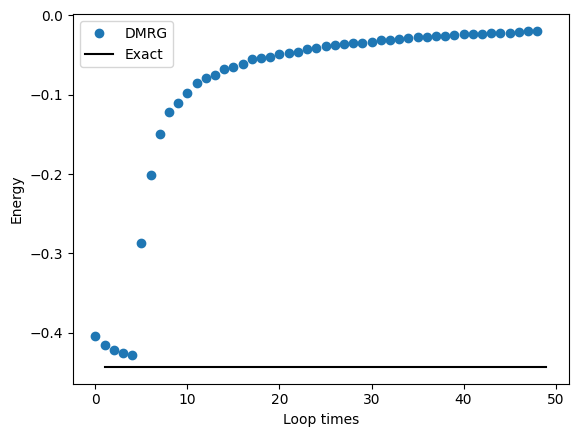

In [18]:
import numpy as np
from scipy.sparse import eye, kron
from scipy.sparse.linalg import eigs

def ptrace(psi, dim1, dim2):
    rho = psi.reshape(dim2, dim1)
    DM2 = rho @ rho.conj().T
    DM1 = rho.conj().T @ rho
    return DM1, DM2

def rotate2NewBasis(Block):
    Block['Ham'] = Block['rotationMatrix'].conj().T @ Block['Ham'] @ Block['rotationMatrix']
    Block['Splus'] = Block['rotationMatrix'].conj().T @ Block['Splus'] @ Block['rotationMatrix']
    Block['Sz'] = Block['rotationMatrix'].conj().T @ Block['Sz'] @ Block['rotationMatrix']
    return Block

LatticeLength = 100  # Adjusted for quicker computation, you can set it back to 200
MaximalStates = 32
Dim = 2  # Local dimension
J = 1

# Construct Spin operator
Sx = 1/2 * np.array([[0, 1], [1, 0]])
Sy = 1/2 * np.array([[0, -1j], [1j, 0]])
Sz = 1/2 * np.array([[-1, 0], [0, 1]])
Splus = Sx + 1j * Sy

sysBlock = {'Ham': np.zeros(Sx.shape), 'Splus': Splus, 'Sz': Sz, 'Length': 1}
envBlock = {'Ham': np.zeros(Sx.shape), 'Splus': Splus, 'Sz': Sz, 'Length': 1}

E_GS = []

while (sysBlock['Length'] + envBlock['Length']) < LatticeLength:
    sysBlock['Ham'] = kron(sysBlock['Ham'], eye(Dim)) + \
                      J/2 * (kron(sysBlock['Splus'].conj().T, Splus) + kron(sysBlock['Splus'], Splus.conj().T)) + \
                      J * kron(sysBlock['Sz'], Sz)
    envBlock['Ham'] = kron(eye(Dim), envBlock['Ham']) + \
                      J/2 * (kron(Splus, envBlock['Splus'].conj().T) + kron(Splus.conj().T, envBlock['Splus'])) + \
                      J * kron(Sz, envBlock['Sz'])
    
    sysBlock['Ham'] = (sysBlock['Ham'] + sysBlock['Ham'].conj().T) / 2
    envBlock['Ham'] = (envBlock['Ham'] + envBlock['Ham'].conj().T) / 2
    
    sysBlock['Splus'] = kron(eye(sysBlock['Ham'].shape[0] // Dim), Splus)
    sysBlock['Sz'] = kron(eye(sysBlock['Ham'].shape[0] // Dim), Sz)
    envBlock['Splus'] = kron(Splus, eye(envBlock['Ham'].shape[0] // Dim))
    envBlock['Sz'] = kron(Sz, eye(envBlock['Ham'].shape[0] // Dim))
    sysBlock['Length'] += 1
    envBlock['Length'] += 1
    
    Hsuper = kron(sysBlock['Ham'], eye(envBlock['Ham'].shape[0])) + \
             kron(eye(envBlock['Ham'].shape[0]), envBlock['Ham']) + \
             J/2 * (kron(sysBlock['Splus'].conj().T, envBlock['Splus']) + kron(sysBlock['Splus'], envBlock['Splus'].conj().T)) + \
             J * kron(sysBlock['Sz'], envBlock['Sz'])
    
    E_GS0, Psi_GS = eigs(Hsuper, k=1, which='SR')
    E_GS.append(E_GS0[0].real / (sysBlock['Length'] + envBlock['Length']))
    sysBlock['DM'], envBlock['DM'] = ptrace(Psi_GS, sysBlock['Ham'].shape[0], envBlock['Ham'].shape[0])
    
    sysBlock['DM'] = (sysBlock['DM'] + sysBlock['DM'].conj().T) / 2
    envBlock['DM'] = (envBlock['DM'] + envBlock['DM'].conj().T) / 2
    
    sysBlock['weight'], sysBlock['rotationMatrix'] = np.linalg.eigh(sysBlock['DM'])
    envBlock['weight'], envBlock['rotationMatrix'] = np.linalg.eigh(envBlock['DM'])
    sysBlock['weight'], Isys = np.sort(sysBlock['weight'])[::-1], np.argsort(sysBlock['weight'])[::-1]
    envBlock['weight'], Ienv = np.sort(envBlock['weight'])[::-1], np.argsort(envBlock['weight'])[::-1]
    
    sysBlock['rotationMatrix'] = sysBlock['rotationMatrix'][:, Isys[:min(MaximalStates, len(Isys))]]
    envBlock['rotationMatrix'] = envBlock['rotationMatrix'][:, Ienv[:min(MaximalStates, len(Ienv))]]
    
    sysBlock = rotate2NewBasis(sysBlock)
    envBlock = rotate2NewBasis(envBlock)
    
    print(f'Total length = {sysBlock["Length"] + envBlock["Length"]}')

import matplotlib.pyplot as plt

plt.figure()
plt.plot(E_GS, 'o', label='DMRG')
plt.plot(range(1, len(E_GS) + 1), [1/4 - np.log(2)] * len(E_GS), 'k', label='Exact')
plt.xlabel('Loop times')
plt.ylabel('Energy')
plt.legend()
plt.show()


In [20]:
import numpy as np
import scipy as sp
from scipy.sparse import kron,identity
from scipy.sparse.linalg import eigsh
from scipy.linalg import eigh
def conn(block_splus,block_sz):
    return 1/2*(kron(block_splus,np.transpose(splus))+kron(np.transpose(block_splus),splus))+kron(block_sz,sz)
def gen_block_hm(block_hm,block_splus,block_sz):
    return kron(block_hm,identity(2))+conn(block_splus,block_sz)
def total_conn(block_splus,block_sz):
    return 1/2*(kron(block_splus,np.transpose(block_splus))+kron(np.transpose(block_splus),block_splus))+kron(block_sz,block_sz)
def total_hm(block_size,block_hm,block_splus,block_sz):
    return kron(block_hm,identity(block_size))+kron(identity(block_size),block_hm)+total_conn(block_splus,block_sz)
def rep_trans(operator,transform_matrix):
    return np.transpose(transform_matrix)@operator@transform_matrix
def DMRG(block_hm,block_splus,block_sz):
    block_size=np.size(block_hm,0)
    block_hm=gen_block_hm(block_hm,block_splus,block_sz)
    block_splus=kron(identity(block_size),splus)
    block_sz=kron(identity(block_size),sz)
    block_size=block_size*2
    hm=total_hm(block_size,block_hm,block_splus,block_sz)   
    energy,psi=eigsh(hm,k=1,which="SA")
    psi=psi.reshape([block_size,-1],order="C")
    rho=np.dot(psi,np.transpose(psi))
    eig_value,eig_vector=eigh(rho)
    basis_dim=min(block_size,cut)
    transform_matrix=np.zeros((block_size,basis_dim),dtype=np.double,order="F")
    for i in range(basis_dim):
        transform_matrix[:,i]=eig_vector[:,block_size-i-1]
    error=sum([eig1 for eig1 in eig_value[0:block_size-cut]])
    print("error:",error)
    block_hm=rep_trans(block_hm,transform_matrix)
    block_splus=rep_trans(block_splus,transform_matrix)
    block_sz=rep_trans(block_sz,transform_matrix)
    return energy,block_hm,block_splus,block_sz
def inf_dmrg():
    k=1
    block_hm=np.copy(init_hm)
    block_splus=np.copy(splus)
    block_sz=np.copy(sz)
    psi=[]
    while 2*k<n:
        print("n=",2*k+2)
        energy,block_hm,block_splus,block_sz=DMRG(block_hm,block_splus,block_sz)
        print("E/n:",energy/(2*k+2))
        k=k+1
if __name__ == '__main__':
    cut=20
    n=200
    init_hm=np.array([[0,0],[0,0]],dtype=np.double)
    sz=np.array([[0.5,0],[0,-0.5]],dtype=np.double)
    splus=np.array([[0,1],[0,0]],dtype=np.double)
    inf_dmrg()

n= 4
error: 0
E/n: [-0.40400635]
n= 6
error: 0
E/n: [-0.41559619]
n= 8
error: 5.4266811101797447e-05
E/n: [-0.42186657]
n= 10
error: 9.166341596201406e-11
E/n: [-0.42580352]
n= 12
error: 3.1294816937153744e-10
E/n: [-0.42850755]
n= 14
error: 1.6584666777698368e-09
E/n: [-0.43048033]
n= 16
error: 4.333191526667645e-09
E/n: [-0.43198356]
n= 18
error: 1.0037189947801573e-08
E/n: [-0.43316726]
n= 20
error: 1.853626146774525e-08
E/n: [-0.43412363]
n= 22
error: 3.338432990131594e-08
E/n: [-0.43491248]
n= 24
error: 4.786561790924603e-08
E/n: [-0.43557431]
n= 26
error: 7.762831197657354e-08
E/n: [-0.43613754]
n= 28
error: 9.409576734354539e-08
E/n: [-0.43662268]
n= 30
error: 1.4473940273972138e-07
E/n: [-0.43704493]
n= 32
error: 1.5656966257234034e-07
E/n: [-0.43741577]
n= 34
error: 2.3367886498307726e-07
E/n: [-0.43774406]
n= 36
error: 2.332857407030683e-07
E/n: [-0.43803672]
n= 38
error: 3.417492509868993e-07
E/n: [-0.43829925]
n= 40
error: 3.216935971590483e-07
E/n: [-0.43853608]
n= 42
erro